In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='02:00:00')
w = cluster.scale(1*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.63:35602 Dashboard: http://10.135.36.63:8787/status,Cluster Workers: 12 Cores: 12 Memory: 200.04 GB


___________
# Useful info.

In [5]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])

# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))

______________
## Part 1. Spectral integrals (lat, KE) -- i.e. zonally averaged KE

## e.g. low-freq $\int_{0}^{0.5 cpd} E_{ageo}(\omega, lat) d\omega$ vs.  high-freq $\int_{0.5 cpd}^{12 cpd} E_{ageo}(\omega, lat) d\omega$

# Ageo uv

In [20]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#F = [1, 2, 4, 5, 7, 8, 10, 11]

v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_all/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
df=E_ageo_zav.freq_time[1]-E_ageo_zav.freq_time[0]

f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_ageo_zav.latitude))
f_cpd = f*86400/2./np.pi

E_all = (E_ageo_zav*df).sum(dim='freq_time')
E_all = E_all.chunk({'latitude': 1}) 
E_ageo_all = np.real(E_all).rename('E_ageo_all')

E_f = (E_ageo_zav.where(abs(E_ageo_zav.freq_time+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_ageo_zav.latitude)>0)
E_f = E_f.chunk({'latitude': 1}) 
E_f = np.real(E_f).rename('E_f')

E_semi = (E_ageo_zav.where( (abs(E_ageo_zav.freq_time)>1.9) & (abs(E_ageo_zav.freq_time)<2.1) )*df).sum(dim='freq_time')
E_semi = E_semi.chunk({'latitude': 1}) 
E_semi = np.real(E_semi).rename('E_semi')

E_diurnal = (E_ageo_zav.where( (abs(E_ageo_zav.freq_time)>0.9) & (abs(E_ageo_zav.freq_time)<1.1) )*df).sum(dim='freq_time')
E_diurnal = E_diurnal.chunk({'latitude': 1}) 
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

E_super = (E_ageo_zav.where( (abs(E_ageo_zav.freq_time)>2.1) & (abs(E_ageo_zav.freq_time)<12) )*df).sum(dim='freq_time')
E_super = E_super.chunk({'latitude': 1}) 
E_super = np.real(E_super).rename('E_super')

In [21]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')

E_high = (E_ageo_zav.where((abs(E_ageo_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_high = E_high.chunk({'latitude': 1}) 
E_ageo_high = np.real(E_high).rename('E_ageo_high')

E_low = E_ageo_all - E_ageo_high
E_low = E_low.chunk({'latitude': 1}) 
E_ageo_low = np.real(E_low).rename('E_ageo_low')

E_f_window = (E_ageo_zav.where(abs(E_ageo_zav.freq_time+f_cpd)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_ageo_zav.latitude)>15)
E_f_window = E_f.chunk({'latitude': 1}) 
E_f_window = np.real(E_f).rename('E_f')

# Geo uv

In [8]:
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_all/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
E_all = (E_geo_zav*df).sum(dim='freq_time')
E_all = E_all.chunk({'latitude': 1}) 
E_geo_all = np.real(E_all).rename('E_geo_all')

In [9]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
E_high = (E_geo_zav.where((abs(E_geo_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_high = E_high.chunk({'latitude': 1}) 
E_geo_high = np.real(E_high).rename('E_geo_high')

E_low = E_geo_all - E_geo_high
E_low = E_low.chunk({'latitude': 1}) 
E_geo_low = np.real(E_low).rename('E_geo_low')

# total uv

In [10]:
v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_all/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
E_all = (E_total_zav*df).sum(dim='freq_time')
E_all = E_all.chunk({'latitude': 1}) 
E_total_all = np.real(E_all).rename('E_total_all')

In [11]:
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')

E_high = (E_total_zav.where((abs(E_total_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_high = E_high.chunk({'latitude': 1}) 
E_total_high = np.real(E_high).rename('E_total_high')

E_low = E_total_all - E_total_high
E_low = E_low.chunk({'latitude': 1}) 
E_total_low = np.real(E_low).rename('E_total_low')

## Figures

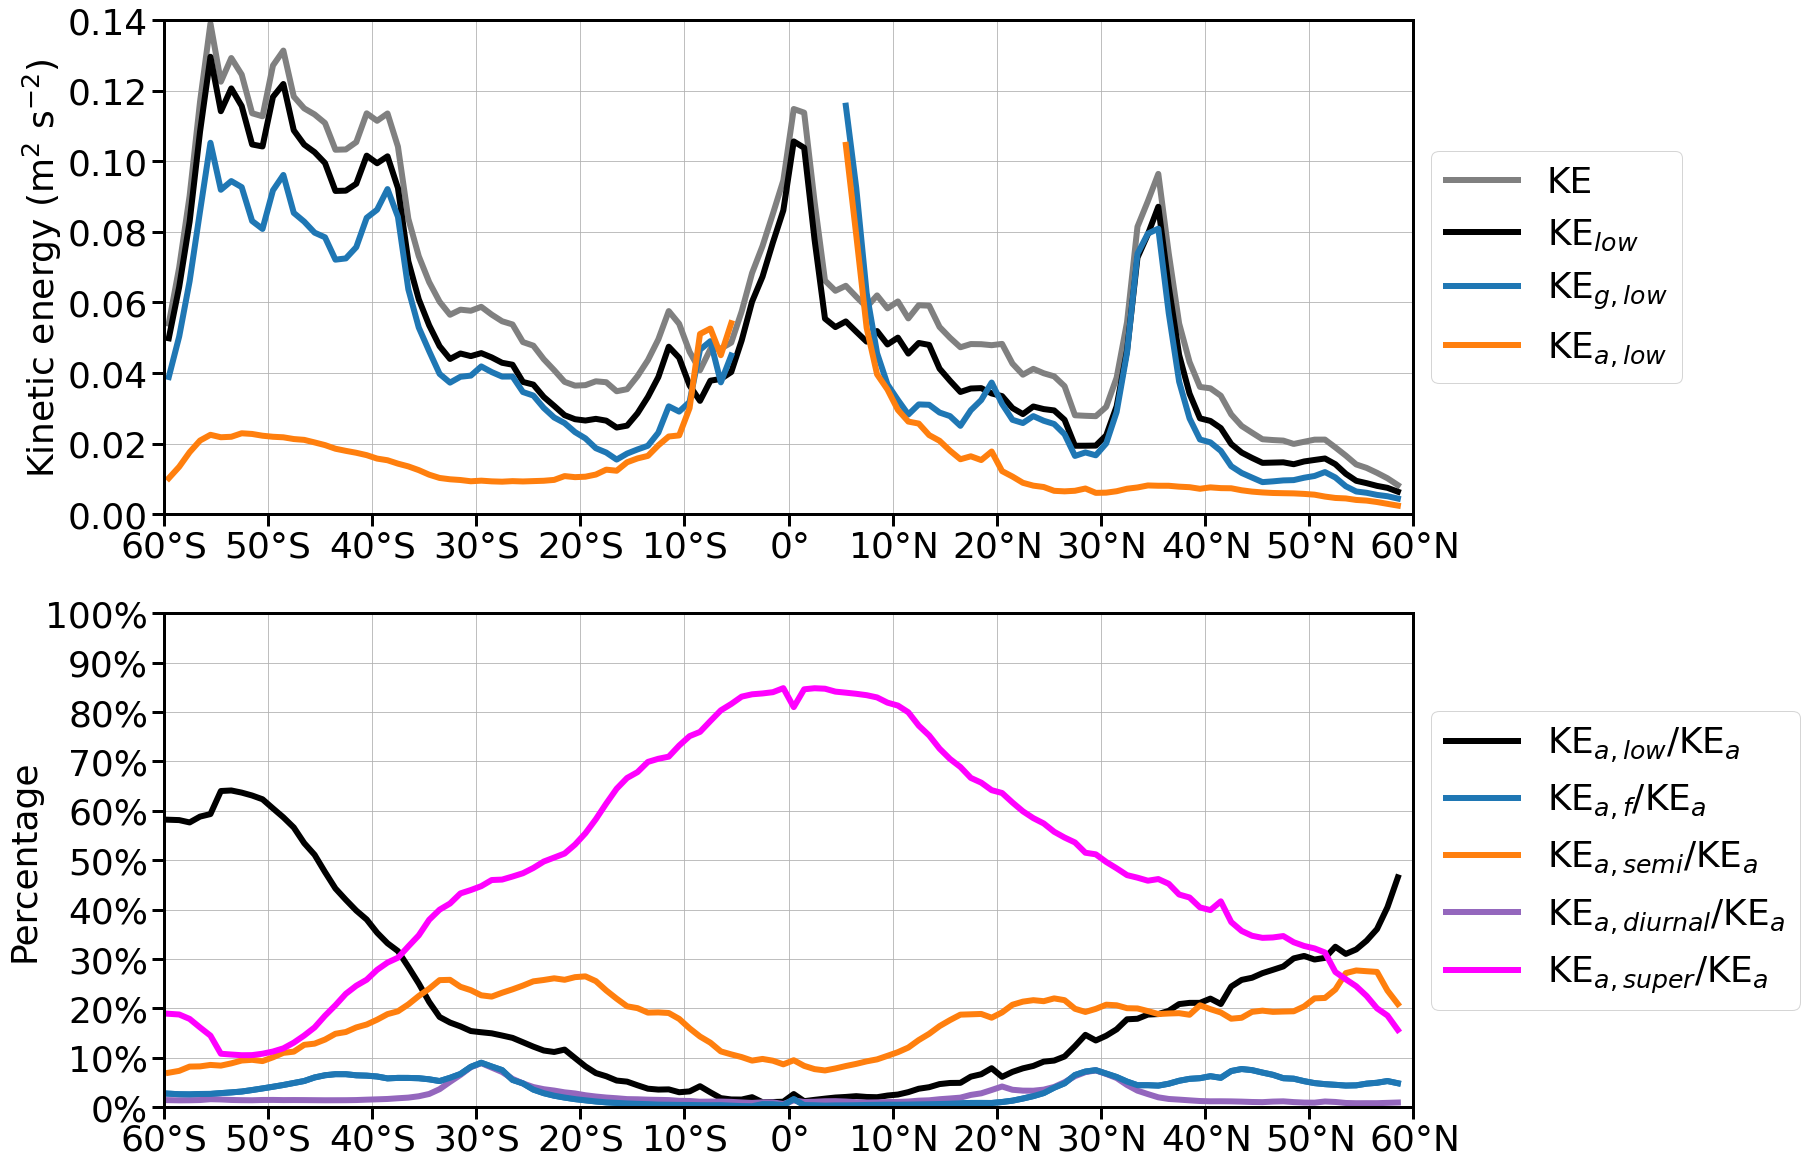

In [15]:
font_size = 36
linewidth = 6

fig, ax = plt.subplots(figsize=(28,20))

labels = ['KE$_{low}$', 'KE$_{g,low}$', 'KE$_{a,low}$','KE','KE$_{high}$']
ax=plt.subplot(211)
(E_total_all).plot(ax=ax,x='latitude',color='grey',label=labels[3],  linewidth=linewidth, linestyle='-')
(E_total_low).plot(ax=ax,x='latitude',color='black',label=labels[0],  linewidth=linewidth)
(E_geo_low.where((np.abs(E_geo_low.latitude)>5))).plot(ax=ax,x='latitude',color='tab:blue',label=labels[1],  linewidth=linewidth)
(E_ageo_low.where((np.abs(E_ageo_low.latitude)>5))).plot(ax=ax,x='latitude',color='tab:orange',label=labels[2], linewidth=linewidth)
#(E_total_high).plot(ax=ax,x='latitude',color='green',label=labels[5],  linewidth=5)
ax.grid()
ax.legend()
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim(0, 0.14)
ax.set_yticks(np.arange(0, 0.15, 0.02))
#ax.set_yticklabels(['0','','0.03','','0.06','','0.09','','0.12','','0.15'])
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('Kinetic energy (m$^2$ s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})    
ax.tick_params(direction='out', length=12, width=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

labels = ['KE$_{a,low}$/KE$_a$', 'KE$_{a,f}$/KE$_a$', 'KE$_{a,semi}}$/KE$_a$', 'KE$_{a,diurnal}}$/KE$_a$', 'KE$_{a,super}$/KE$_a$']
ax=plt.subplot(212)
( (E_ageo_low) /E_ageo_all).plot(ax=ax,x='latitude',color='black',label=labels[0], linewidth=linewidth)
(E_f/E_ageo_all).plot(ax=ax,x='latitude',color='tab:blue',label=labels[1], linewidth=linewidth)
(E_semi/E_ageo_all).plot(ax=ax,x='latitude',color='tab:orange',label=labels[2], linewidth=linewidth)
(E_diurnal/E_ageo_all).plot(ax=ax,x='latitude',color='tab:purple',label=labels[3], linewidth=linewidth)
( (E_super) /E_ageo_all).plot(ax=ax,x='latitude',color='magenta',label=labels[4], linewidth=linewidth)
(E_f/E_ageo_all).plot(ax=ax,x='latitude',color='tab:blue', linewidth=linewidth)
ax.grid()
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel('Percentage',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.legend(prop={'size': font_size})
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='upper right', frameon=True ,prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.tick_params(direction='out', length=12, width=3)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_05_dpi300.png',dpi=300)

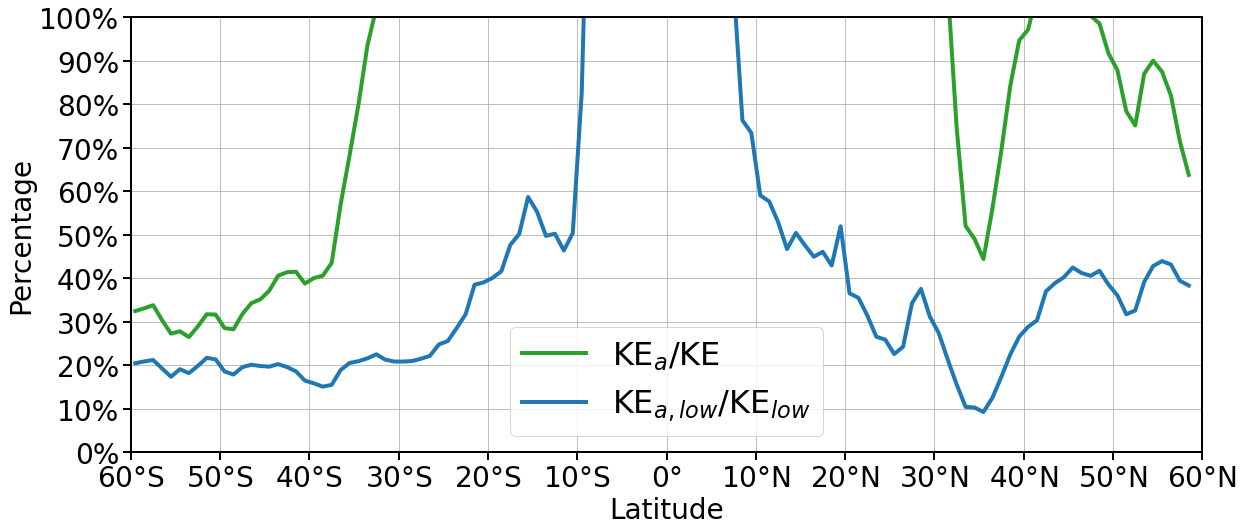

In [17]:
font_size = 28

fig, ax = plt.subplots(figsize=(24,8))

labels = ['KE$_a$/KE','KE$_{a,low}$/KE$_{low}$','KE$_f$/KE']
ax=plt.subplot(111)
(E_ageo_all.where((np.abs(E_geo_low.latitude)>10))/E_total_all.where((np.abs(E_geo_low.latitude)>10))).plot(ax=ax,x='latitude',color='tab:green',label=labels[0], linewidth=4)
(E_ageo_low.where((np.abs(E_geo_low.latitude)>5))/E_total_low.where((np.abs(E_geo_low.latitude)>5))).plot(ax=ax,x='latitude',color='tab:blue',label=labels[1],  linewidth=4)
ax.grid()
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
#ax.legend(prop={'size': font_size})
ax.set_xlabel('Latitude',fontsize=font_size)
ax.set_ylabel('Percentage',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='lower center',prop={'size': 32})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_06c_dpi180.png',dpi=180)

In [28]:
cluster.close()